# Описание проекта

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

# 1. Подготовка данных

### 1.1 Изучение данных

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error

In [3]:
# загрузим таблицы
gold_recovery_train=pd.read_csv("//datasets//gold_recovery_train.csv")
gold_recovery_test=pd.read_csv("//datasets//gold_recovery_test.csv")
gold_recovery_full=pd.read_csv("//datasets//gold_recovery_full.csv")

In [4]:
# изучим полные данные
gold_recovery_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
date                                                  22716 non-null object
final.output.concentrate_ag                           22627 non-null float64
final.output.concentrate_pb                           22629 non-null float64
final.output.concentrate_sol                          22331 non-null float64
final.output.concentrate_au                           22630 non-null float64
final.output.recovery                                 20753 non-null float64
final.output.tail_ag                                  22633 non-null float64
final.output.tail_pb                                  22516 non-null float64
final.output.tail_sol                                 22445 non-null float64
final.output.tail_au                                  22635 non-null float64
primary_cleaner.input.sulfate                         21107 non-null float64
primary_cleaner.input.depressant             

In [5]:
# ичучим обучающие данные
gold_recovery_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null object
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant             

In [6]:
# изучим тестовые данные
gold_recovery_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
date                                          5856 non-null object
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_air        5840 non-null float64
primary_cleaner.state.floatbank8_d_level      5840 non-null float64
rougher.in

#### Вывод к пункту 1.1

В полных и обучающих данных 87 столбцов, из них столбцы final.output.recovery и rougher.output.recovery- целевые признаки. А в тестовой выборке 57 столбцов, так как отсутствуют данные о финальных концентрациях металлов и все столбцы с параметрами продукта (output). В дыльнейшем, при обучении модели в обучающей выборке необходимо будет также удалить эти столбцы, а в тестовую выборку добавить целевые признаки.

### 1.2 Проверка расчёта эффективности обогащения.

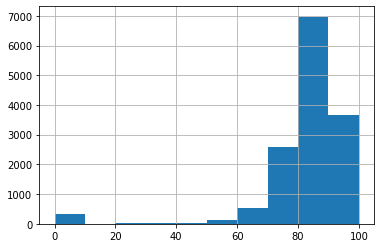

In [7]:
# построим гистограмму распределения концентраций веществ после черновой очистки
gold_recovery_train['rougher.output.recovery'].hist()

Диапазон значений эффективности обогащения лежит от нуля до ста с пиком 80-90%.

In [8]:
# функция для вычисления эффективности обогащения
def recovery_cout(data):
    c=data['rougher.output.concentrate_au']
    f=data['rougher.input.feed_au']
    t=data['rougher.output.tail_au']
    for i in range(len(data)):
        recovery=((c*(f-t))/(f*(c-t)))*100
    return recovery              

In [9]:
# расчитаем эффективность обогащения
recovery=recovery_cout(gold_recovery_train)
recovery=recovery.fillna(method='ffill')

In [10]:
recovery.max()

inf

In [11]:
recovery.min()

-inf

Для  recovery, вычисленной по формуле, значения минимума и максимума лежат от минус до плюс бесконечности. Сделаем так, чтобы диапазон значений был такой же как у столбца rougher.output.recovery: значения меньше нуля заменим на ноль, а значения больше ста на сто.

In [12]:
for i in recovery:
    if i<0.0:
        recovery=recovery.replace(i,0)
    if i>100.0:
        recovery=recovery.replace(i,100)

In [13]:
recovery=recovery.astype('int')

In [14]:
# создадим Series из столбца rougher.output.recovery
# и заполним пропущенные значения значениями из предыдущих результатов,
# так как соседние по времени параметры часто похожи
rougher_output_recovery=gold_recovery_train['rougher.output.recovery'].fillna(method='ffill').astype('int')

In [15]:
# Посчитаем наскольно правильно расчитана эффективность обогащения:
# посчитаем средний модуль отклонения между расчётами и значениями признака
mae = mean_absolute_error(rougher_output_recovery, recovery)
print('MAE между целевым признаком и расчётом:', '{:.2f}%' .format(mae))

MAE между целевым признаком и расчётом: 3.97%


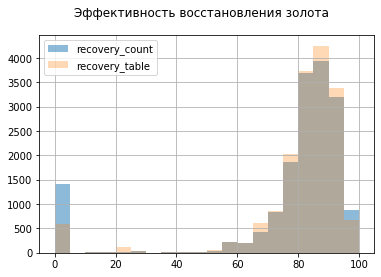

In [16]:
# построим гистограмму для иллюстрации разницы в эффективности восстановления золота между 
# предполагаемыми расчётными значениями  и значением признака
labels=["recovery_count","recovery_table"]
fig=recovery.hist(bins=20, alpha = 0.5)
fig=rougher_output_recovery.hist(bins=20,alpha = 0.3)
plt.legend(labels)
fig.figure.suptitle("Эффективность восстановления золота", fontsize = 12)
plt.show()


Разница в эффективности восстановления золота между табличным и расчётным значениями составило 3.97%. По гистограмме видно, что пики совдают, но при расчёте чаще встречаются крайние значения-около нуля и ста процентов, что сказывается на доле основных пиков.

### 1.4 Предобработка данных

In [17]:
# заменим все пропущенные значения значениями из предыдущих результатов,
# так как соседние по времени параметры часто похожи
gold_recovery_train=gold_recovery_train.fillna(method='ffill')
gold_recovery_test=gold_recovery_test.fillna(method='ffill')
gold_recovery_full=gold_recovery_full.fillna(method='ffill')

In [18]:
# добавим в тестовую выборку значения целевых признаков из общей таблицы по дате
gold_recovery_test = gold_recovery_test.merge(gold_recovery_full[['date','rougher.output.recovery']], on='date')
gold_recovery_test = gold_recovery_test.merge(gold_recovery_full[['date','final.output.recovery']], on='date')

Разделение данных по признакам будет проводиться в пункте 3.

# 2. Анализ данных

### 2.1 Посмотрим как меняется концентрация металлов на различных этапах очистки

#### 2.1.1 Изменение концентрации Au

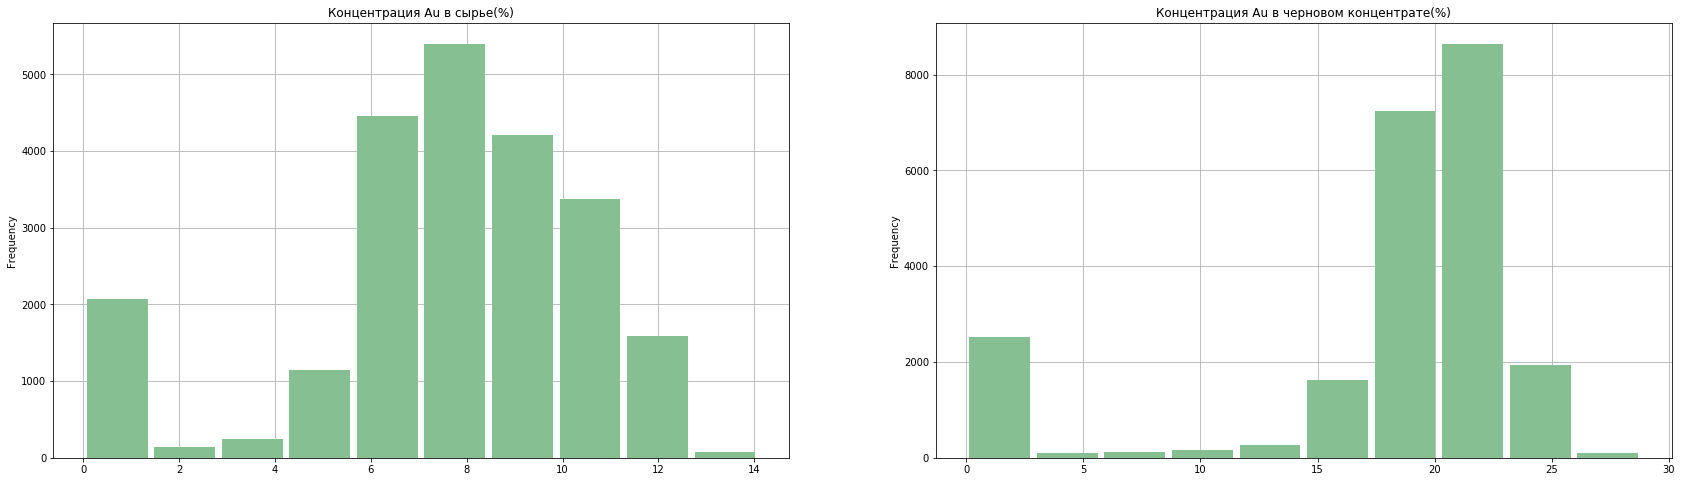

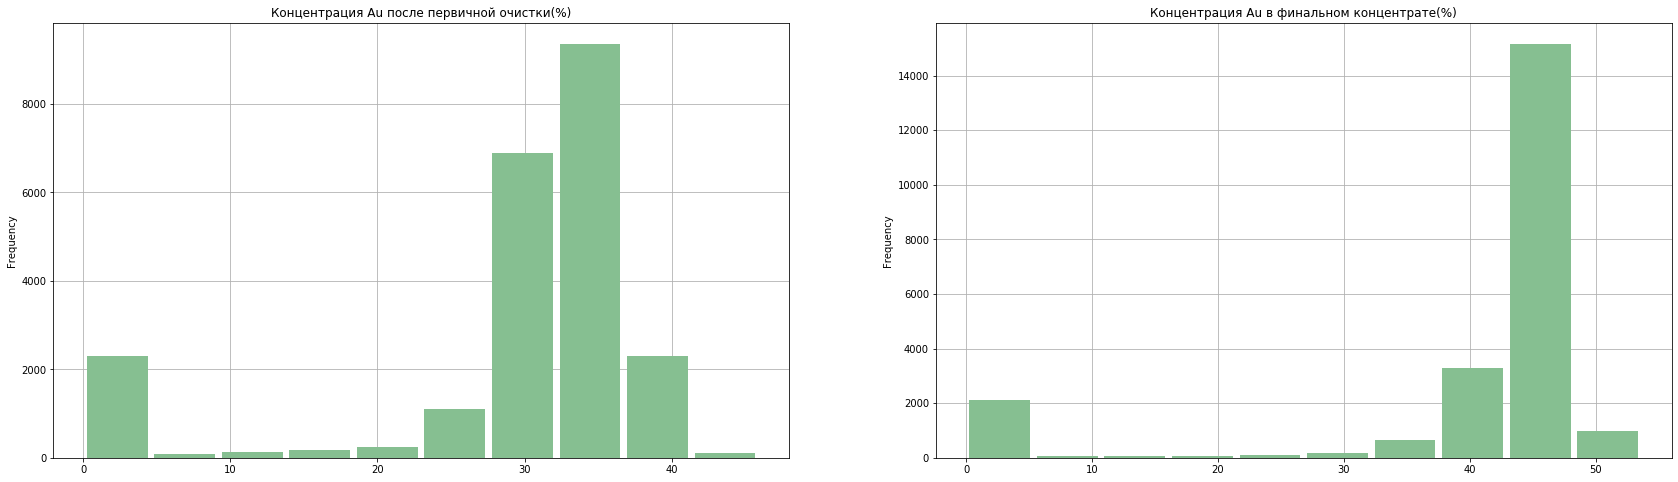

In [19]:
fig, axs=plt.subplots(1,2, figsize=(29,8))
gold_recovery_full['rougher.input.feed_au'].plot(kind='hist',title='Концентрация Au в сырье(%)',grid=True, color='#86bf91', zorder=2, rwidth=0.9, ax=axs[0])
gold_recovery_full['rougher.output.concentrate_au'].plot(kind='hist',title='Концентрация Au в черновом концентрате(%)',grid=True, color='#86bf91', zorder=2, rwidth=0.9, ax=axs[1])
plt.show()
fig, axs=plt.subplots(1,2, figsize=(29,8))
gold_recovery_full['primary_cleaner.output.concentrate_au'].plot(kind='hist',title='Концентрация Au после первичной очистки(%)',grid=True,color='#86bf91', zorder=2, rwidth=0.9, ax=axs[0])
gold_recovery_full['final.output.concentrate_au'].plot(kind='hist',title='Концентрация Au в финальном концентрате(%)',grid=True, color='#86bf91', zorder=2, rwidth=0.9, ax=axs[1])
plt.show()

#### 2.1.2 Изменение концентрации Ag

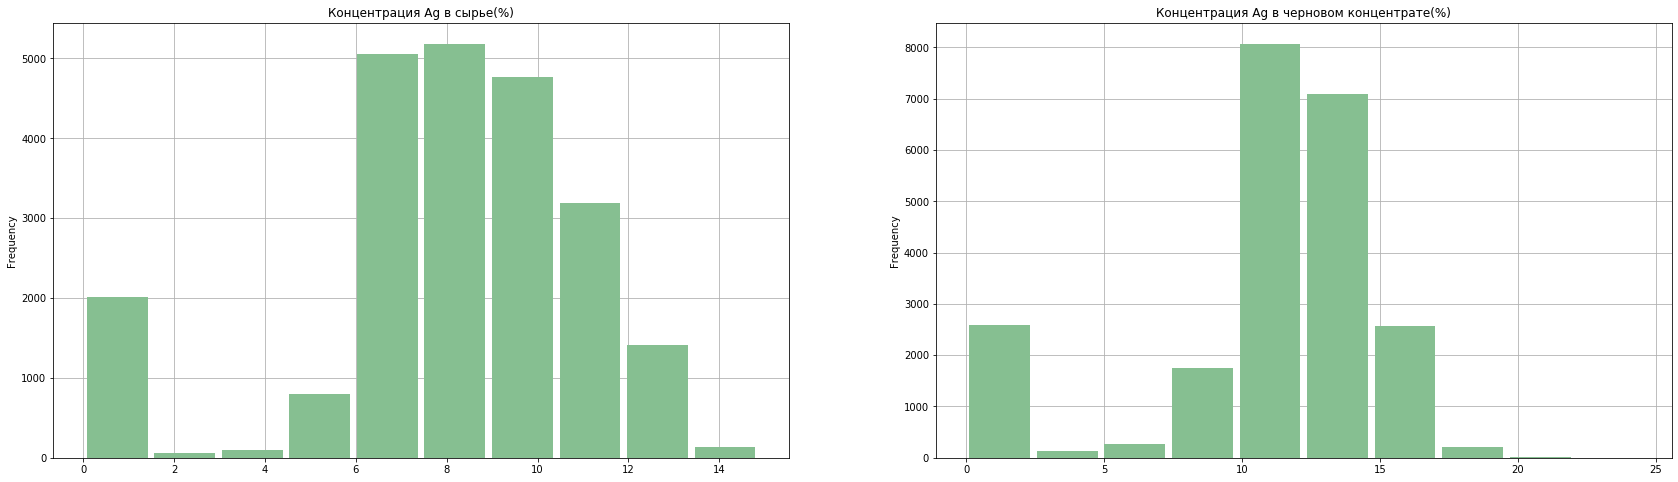

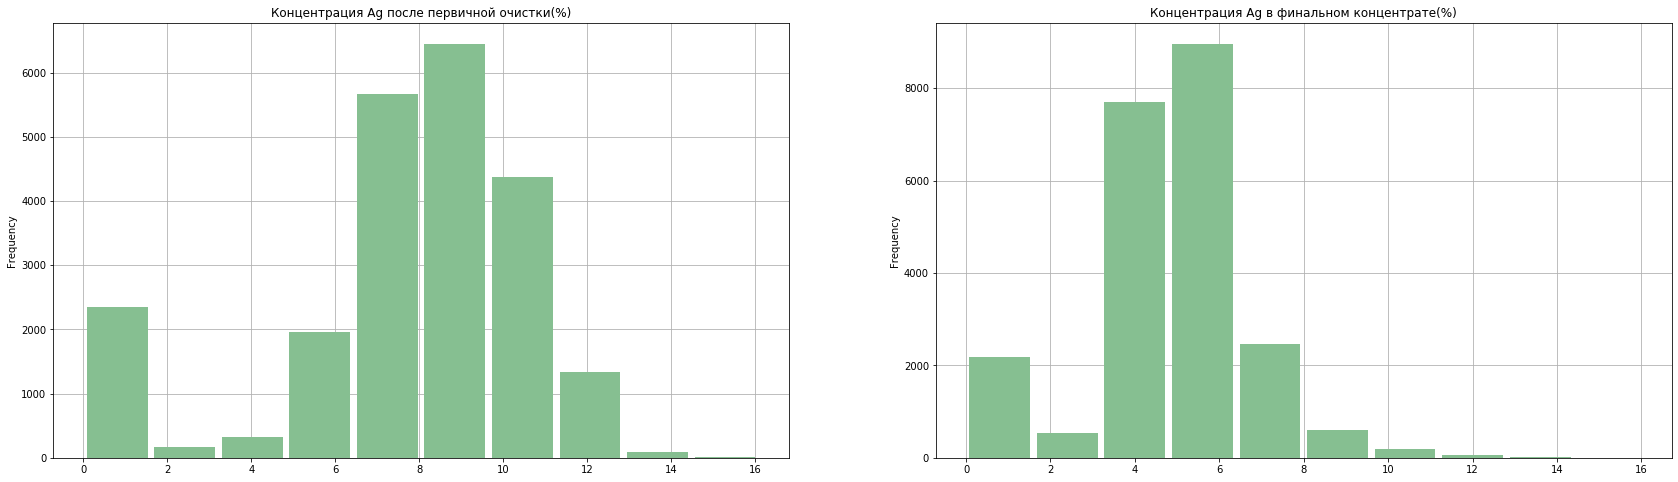

In [20]:
fig, axs=plt.subplots(1,2, figsize=(29,8))
gold_recovery_full['rougher.input.feed_ag'].plot(kind='hist',title='Концентрация Ag в сырье(%)',grid=True, color='#86bf91', zorder=2, rwidth=0.9, ax=axs[0])
gold_recovery_full['rougher.output.concentrate_ag'].plot(kind='hist',title='Концентрация Ag в черновом концентрате(%)',grid=True, color='#86bf91', zorder=2, rwidth=0.9, ax=axs[1])
plt.show()
fig, axs=plt.subplots(1,2, figsize=(29,8))
gold_recovery_full['primary_cleaner.output.concentrate_ag'].plot(kind='hist',title='Концентрация Ag после первичной очистки(%)',grid=True,color='#86bf91', zorder=2, rwidth=0.9, ax=axs[0])
gold_recovery_full['final.output.concentrate_ag'].plot(kind='hist',title='Концентрация Ag в финальном концентрате(%)',grid=True, color='#86bf91', zorder=2, rwidth=0.9, ax=axs[1])
plt.show()

#### 2.1.3 Изменение концентрации Pb

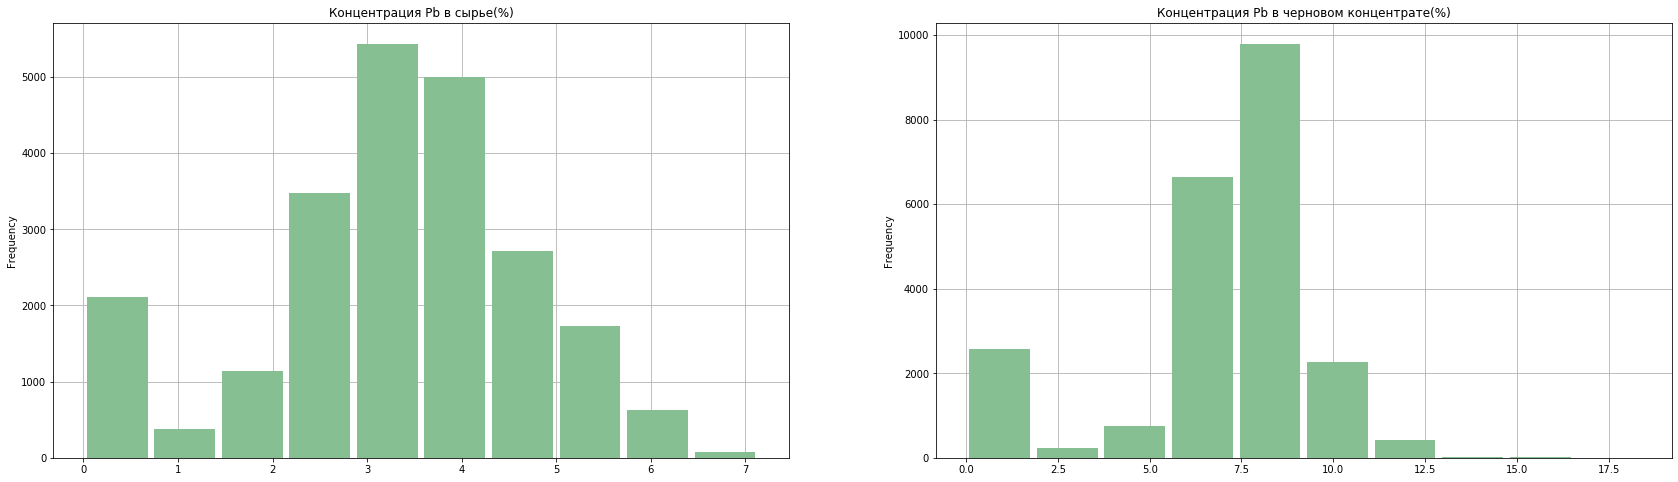

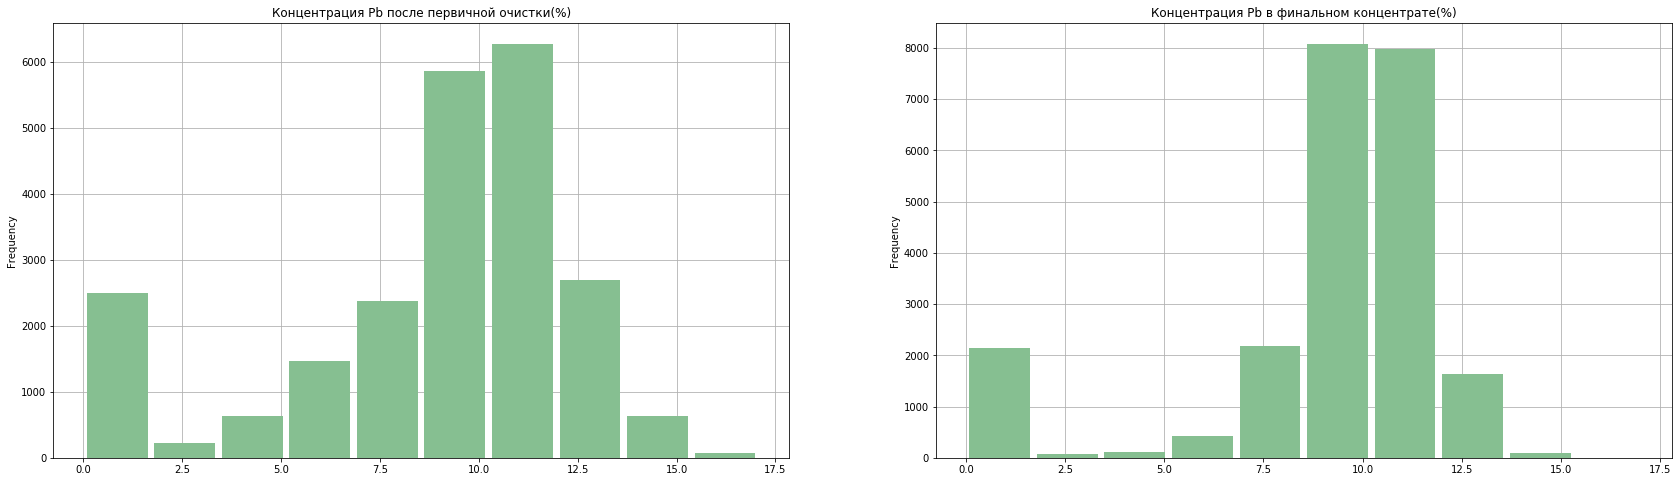

In [21]:
fig, axs=plt.subplots(1,2, figsize=(29,8))
gold_recovery_full['rougher.input.feed_pb'].plot(kind='hist',title='Концентрация Pb в сырье(%)',grid=True, color='#86bf91', zorder=2, rwidth=0.9, ax=axs[0])
gold_recovery_full['rougher.output.concentrate_pb'].plot(kind='hist',title='Концентрация Pb в черновом концентрате(%)',grid=True, color='#86bf91', zorder=2, rwidth=0.9, ax=axs[1])
plt.show()
fig, axs=plt.subplots(1,2, figsize=(29,8))
gold_recovery_full['primary_cleaner.output.concentrate_pb'].plot(kind='hist',title='Концентрация Pb после первичной очистки(%)',grid=True,color='#86bf91', zorder=2, rwidth=0.9, ax=axs[0])
gold_recovery_full['final.output.concentrate_pb'].plot(kind='hist',title='Концентрация Pb в финальном концентрате(%)',grid=True, color='#86bf91', zorder=2, rwidth=0.9, ax=axs[1])
plt.show()

#### Вывод к пункту 2.1

<dev>1) Максимальная доля Au в финальном концентрате-40%, для него прослеживается четкое увеличение концентрации от доли в сырье к финальному концентрату:от 8% до 40%.Также доля других пиков уменьшается.</dev>

<dev>2) Максимальная доля Ag в финальном концентрате-6%. В сырье концентрация 10%, она увеличиваетсяв в черновом концентрате- 10-11%, а затем прослеживается уменьшение концентрации от чернового к финальному: от 10% до 6%. Также доля других пиков уменьшается.</dev>

<dev>3) Максимальная доля Pb в финальном концентрате-10%, для него прослеживается  увеличение концентрации от доли в сырье к финальному концентрату: от 3% до 10-11%. При этом после первой очистки максимальная концентрация-11%, а в финальном концентрате незначительно преобладает пик-10%. Также доля других пиков уменьшается.</dev>

<dev>4) Во всех графиках прослеживается пик около 0.</dev>

### 2.2 Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках.

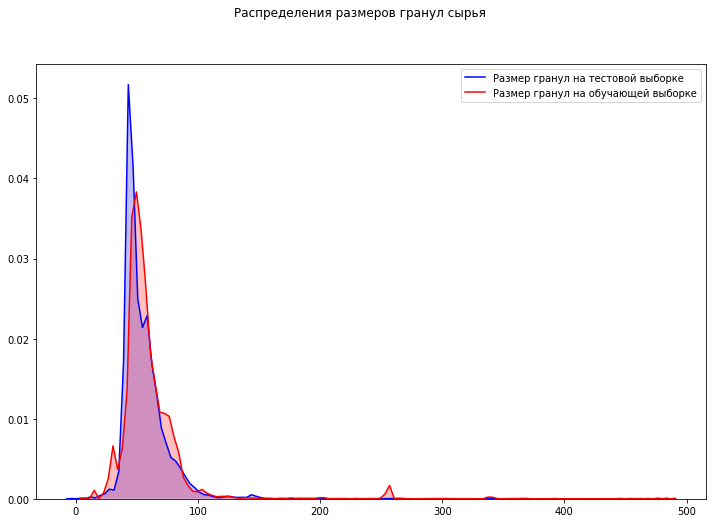

In [22]:
# построим график плотности распределения размеров гранул
fig=plt.subplots(figsize=(12,8))
fig=sns.kdeplot(gold_recovery_test['rougher.input.feed_size'], shade=True,
              color = 'blue', label="Размер гранул на тестовой выборке")

fig=sns.kdeplot(gold_recovery_train['rougher.input.feed_size'],  shade=True,
              color = 'red', 
             label="Размер гранул на обучающей выборке")

fig.figure.suptitle("Распределения размеров гранул сырья", fontsize = 12)

plt.show()

#### Вывод к пункту 2.2

Характер распределения гранул на тестовой и обучающей выборке схож, не должно возникнуть проблем при обучении модели

### 2.3 Исследуeм суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. 

In [23]:
# cуммарная концентрация веществ в сырье
sum_concentrate_input_rougher=gold_recovery_full['rougher.input.feed_ag']+\
                                  gold_recovery_full['rougher.input.feed_au']+\
                                  gold_recovery_full['rougher.input.feed_pb']+\
                                  gold_recovery_full['rougher.input.feed_sol']

In [24]:
# cуммарная концентрация веществ в черновом концентрате
sum_concentrate_output_rougher=gold_recovery_full['rougher.output.concentrate_ag']+\
                                  gold_recovery_full['rougher.output.concentrate_au']+\
                                  gold_recovery_full['rougher.output.concentrate_pb']+\
                                  gold_recovery_full['rougher.output.concentrate_sol']

In [25]:
# cуммарная концентрация веществ в финальном концентрате
sum_concentrate_finall=gold_recovery_full['final.output.concentrate_ag']+\
                                  gold_recovery_full['final.output.concentrate_au']+\
                                  gold_recovery_full['final.output.concentrate_pb']+\
                                  gold_recovery_full['final.output.concentrate_sol']

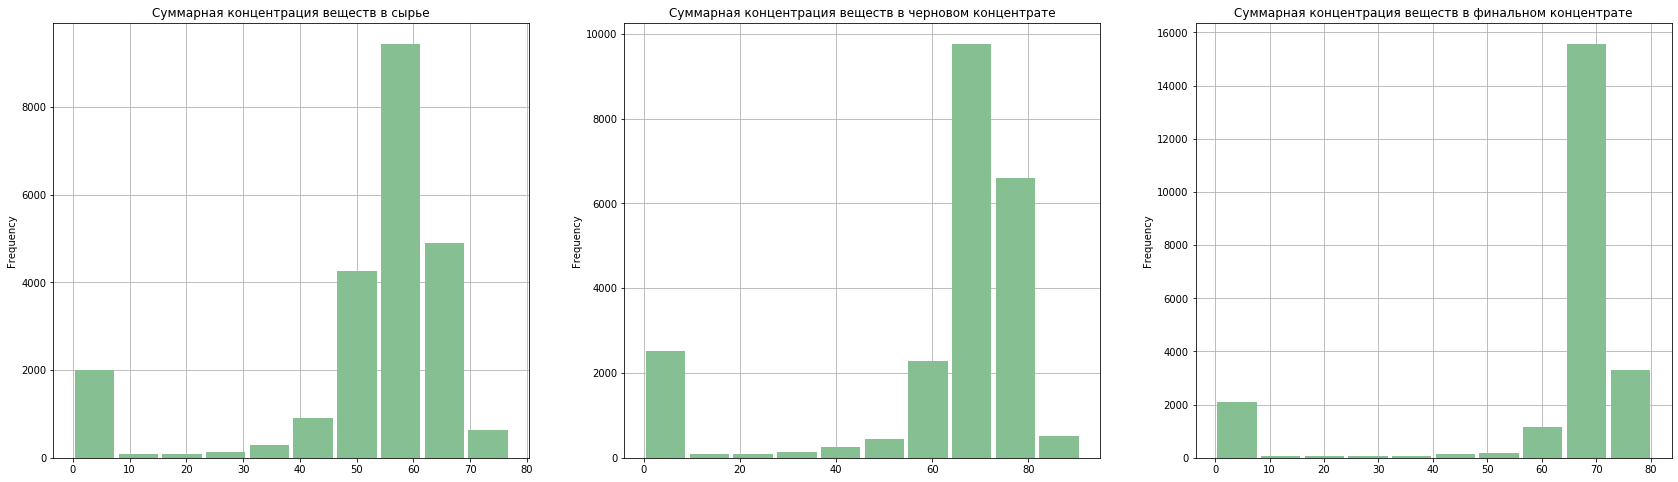

In [26]:
#построим гистограммы распределения суммарных концентраций веществ
fig, axs=plt.subplots(1,3, figsize=(29,8))
sum_concentrate_input_rougher.plot(kind='hist',title='Суммарная концентрация веществ в сырье',grid=True, color='#86bf91', zorder=2, rwidth=0.9, ax=axs[0])
sum_concentrate_output_rougher.plot(kind='hist',title='Суммарная концентрация веществ в черновом концентрате',grid=True,color='#86bf91', zorder=2, rwidth=0.9, ax=axs[1])
sum_concentrate_finall.plot(kind='hist',title='Суммарная концентрация веществ в финальном концентрате',grid=True, color='#86bf91', zorder=2, rwidth=0.9, ax=axs[2])
plt.show()

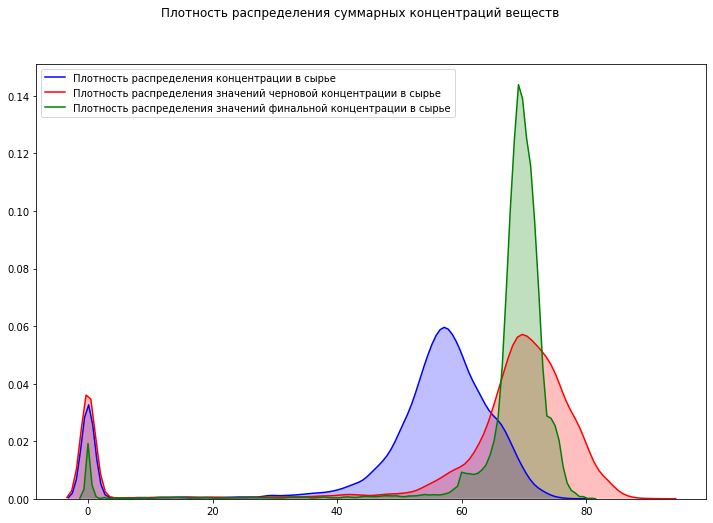

In [27]:
# построим график плотности распределения суммарных концентраций веществ
fig=plt.subplots(figsize=(12,8))
fig=sns.kdeplot(sum_concentrate_input_rougher, shade=True,
              color = 'blue', label="Плотность распределения концентрации в сырье")

fig=sns.kdeplot(sum_concentrate_output_rougher,  shade=True,
              color = 'red', 
             label="Плотность распределения значений черновой концентрации в сырье")
fig=sns.kdeplot(sum_concentrate_finall,  shade=True,
              color = 'green', 
             label="Плотность распределения значений финальной концентрации в сырье")

fig.figure.suptitle("Плотность распределения суммарных концентраций веществ", fontsize = 12)

plt.show()

#### Вывод к пункту 2.3

<dev>1) В финальном концентрате разброс значений уменьшается, продукт очистки становится более очищенным от примесей. По графикам можно проследить степень очистки.</dev>

<dev>2) Также присутствуют пики около нулевого значения.</dev>

### Вывод

Технология очитски успешно работает, но при этом в данных присутствует аномальный пик около нуля, что может быть связано с ошибкой измерения. Этот пик может пожет повлиять на обучение модели, поэтому лучше будет его удалить.

In [28]:
# удалим из тестовой и обучающей выборок значения около нуля
gold_recovery_train=gold_recovery_train[(gold_recovery_train != 0).all(axis=1)]
gold_recovery_test=gold_recovery_test[(gold_recovery_test != 0).all(axis=1)]

# 3. Модель

Подготовка к обучению и валидации моделей: написание функции для итоговой sMAPE, разделение обучающей выборки на обучающую и валидационную.

In [29]:
import numpy as np

In [30]:
#функция для вычисления sMAPE для чернового и финального концентратов
def smape(target, prediction):
    return 100/len(target) * np.sum(2 * np.abs(target - prediction) / (np.abs(target) + np.abs(prediction)))

In [31]:
#функция для вычисления итоговой sMAPE
def end_smape(data):
    return ((0.25*data[0])+(0.75*data[1]))

In [32]:
# удалим в обучающей выборке столбцы, которых нет в тестовой выборке
test_cols = gold_recovery_test.columns
gold_recovery_train_change = gold_recovery_train[gold_recovery_train.columns.intersection(test_cols)]

In [33]:
# Разобьем обучающие и тестовые данные на признаки и целевые признаки
features_train=gold_recovery_train_change.drop(gold_recovery_train_change.columns[[0,1]],axis=1)
target_train=gold_recovery_train_change[['rougher.output.recovery','final.output.recovery']]

features_test=gold_recovery_test.drop(gold_recovery_test.columns[[0,54]],axis=1)
target_test=gold_recovery_test[['rougher.output.recovery','final.output.recovery']]

In [34]:
# для дальнейшей кросс-валидации модели разделим
# обучающую выборку на валидационную и обучающую
block_size = int(len(gold_recovery_train_change)/3)

for i in range(0, len(gold_recovery_train_change), block_size):
    valid_indexes = gold_recovery_train_change.iloc[i: i + block_size].index
    train_indexes = (gold_recovery_train_change.iloc[:i]+gold_recovery_train_change.iloc[i+block_size:]).index
    features_train2=features_train.loc[train_indexes,:]
    target_train2=target_train.loc[train_indexes]
    features_valid=features_train.loc[valid_indexes,:]
    target_valid=target_train.loc[valid_indexes]

In [35]:
# функция для обучения и валидации модели
def cross_model(name):
    model=name
    model.fit(features_train2,target_train2)
    predicted= model.predict(features_valid)
    score = smape(target_valid,predicted)
    final_score=score.mean()
    return (print('Средняя итоговая sMAPE модели:', '{:.2f}%'.format(final_score)))


### 3.1 Модель древо решений

In [36]:
from sklearn.tree import DecisionTreeRegressor

In [37]:
cross_model(DecisionTreeRegressor())

Средняя итоговая sMAPE модели: 6.63%


### 3.2 Модель случайный лес

In [38]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

In [39]:
# Подбираем гиперпараметры estimators и depth
for estimators in range(1,10,1):
    for depth in range(1,10):
        model_forest =RandomForestRegressor(random_state=12345, max_depth= depth, n_estimators=estimators)
        model_forest.fit(features_train2,target_train2)# обучаем модель на обучающей выборке
        predicted_forest = model_forest.predict(features_valid)
        print("estimators =", estimators, ": ", end='')
        print("depth =", depth, ": ", end='')
        print(r2_score(target_valid,predicted_forest))

estimators = 1 : depth = 1 : -0.050967185698092554
estimators = 1 : depth = 2 : 0.44700689971257584
estimators = 1 : depth = 3 : 0.584074846143082
estimators = 1 : depth = 4 : 0.5496215446495565
estimators = 1 : depth = 5 : 0.5565711793755963
estimators = 1 : depth = 6 : 0.5539738403103855
estimators = 1 : depth = 7 : 0.5200381702896872
estimators = 1 : depth = 8 : 0.5361882780702742
estimators = 1 : depth = 9 : 0.5100388862060462
estimators = 2 : depth = 1 : -0.07197631205092037
estimators = 2 : depth = 2 : 0.45370585205060415
estimators = 2 : depth = 3 : 0.48126601943392283
estimators = 2 : depth = 4 : 0.4735997171891229
estimators = 2 : depth = 5 : 0.4448103170301689
estimators = 2 : depth = 6 : 0.437989107855022
estimators = 2 : depth = 7 : 0.43804080761348657
estimators = 2 : depth = 8 : 0.44103683254641957
estimators = 2 : depth = 9 : 0.4243994952625014
estimators = 3 : depth = 1 : -0.07897152502743532
estimators = 3 : depth = 2 : 0.45642158873450844
estimators = 3 : depth = 3 : 

In [40]:
cross_model(RandomForestRegressor(random_state=12345, max_depth=6, n_estimators=9))

Средняя итоговая sMAPE модели: 5.05%


### 3.3 Линейная регрессия

In [41]:
from sklearn.linear_model import LinearRegression

In [42]:
cross_model(LinearRegression())

Средняя итоговая sMAPE модели: 5.16%


### 3.4 Проверяем лучшую модель на тестовой выборке

По итогам валидации лучшая модель- RandomForest, так как у неё удалось получить наименьший процент ошибки прогноза.

In [43]:
model_forest=(RandomForestRegressor(random_state=12345, max_depth=6, n_estimators=5))
model_forest.fit(features_train,target_train)              

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=None,
                      oob_score=False, random_state=12345, verbose=0,
                      warm_start=False)

In [44]:
prediction_test=model_forest.predict(features_test)
score = smape(target_test,prediction_test)
final_score=score.mean()
print('Итогова sMAPE для тестовой модели:', '{:.2f}%'.format(final_score))

Итогова sMAPE для тестовой модели: 8.70%


<dev>1)В итоге для прогноза эффективности обогащения чернового и финального концетратов была выбрана модель RandomForest, так как значение sMAPE на валидационной выборке был наименьший-5.05%, что означает наиболее точный прогноз. </dev>

<dev>2)Значение sMAPE для этой модели на тестовой выборке увеличилась и  составила 8.7%, что больше чем на валидационной. При этом, для тестовой выборки гиперпараметры depth и estimators были изменены для уменьшения вероятности ошибки, так как на изначальных параметрах значение sMAPE тестовой выборки было-10%.</dev>

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке выполнения
- [x]  Выполнен шаг 1: данные подготовлены
    - [x]  Проверена формула вычисления эффективности обогащения
    - [x]  Проанализированы признаки, недоступные в тестовой выборке
    - [x]  Проведена предобработка данных
- [x]  Выполнен шаг 2: данные проанализированы
    - [x]  Исследовано изменение концентрации элементов на каждом этапе
    - [x]  Проанализированы распределения размеров гранул на обучающей и тестовой выборках
    - [x]  Исследованы суммарные концентрации
    - [x]  Проанализированы и обработаны аномальные значения
- [x]  Выполнен шаг 3: построена модель прогнозирования
    - [x]  Написана функция для вычисления итогового *sMAPE*
    - [x]  Обучено и проверено несколько моделей
    - [x]  Выбрана лучшая модель, её качество проверено на тестовой выборке